## BIRDCLEF 2024 - Rami El Wazzi & Sacha Guenoun

### Partie 3 - Training

#### Objectif du projet : entrainer un réseau de neurones permettant de reconnaitre un oiseau grâce à son cri.

In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

### Chargement des propriétés du signal calculées en partie 2

In [3]:
X = np.load("./X.npy")
y = np.load("./y.npy")
df_train = pd.read_csv("./birdclef-2024/train_metadata.csv")[["primary_label", "filename"]]

In [4]:
X.shape

(24459, 684)

In [5]:
df_train["X"] = X.tolist()

# def get_max_audio_length(file_paths):
#     max_length = 0
#     for file_path in file_paths:
#         y, sr = librosa.load(file_path, sr=None)
#         length = len(y)
#         if length > max_length:
#             max_length = length
#     return max_length

# file_paths = df_train['filename'].apply(lambda x: "./birdclef-2024/train_audio/" + x).tolist()

# max_length = get_max_audio_length(file_paths)
# print(f"The maximum length of the audio files is: {max_length} samples")
max_length = 190855200 # already calculated, takes too long to calculate


In [6]:
df_train

,primary_label,filename,X
0,asbfly,asbfly/XC134896.ogg,"[-79.97372436523438, -79.92324829101562, -79.5..."
1,asbfly,asbfly/XC164848.ogg,"[-15.896378517150879, -16.278581619262695, -16..."
2,asbfly,asbfly/XC175797.ogg,"[-58.841304779052734, -53.871551513671875, -55..."
3,asbfly,asbfly/XC207738.ogg,"[-18.35483741760254, -15.606270790100098, -16...."
4,asbfly,asbfly/XC209218.ogg,"[-14.528952598571777, -8.531251907348633, -9.6..."
...,...,...,...
24454,zitcis1,zitcis1/XC845747.ogg,"[-10.991899490356445, -12.973498344421387, -17..."
24455,zitcis1,zitcis1/XC845817.ogg,"[-9.823176383972168, -15.329643249511719, -24...."
24456,zitcis1,zitcis1/XC856176.ogg,"[-26.30453872680664, -12.45651626586914, -8.18..."
24457,zitcis1,zitcis1/XC856723.ogg,"[-24.176374435424805, -19.10907745361328, -18...."


In [7]:
len(df_train["X"]), len(df_train["X"].iloc[0])

(24459, 684)

### Après plusieurs essais tests, nous décidons d'entrainer un CNN contenant l'image du spectrogramme (partie 1) ET les propriétés du signal (partie 2) pour s'assurer la meilleure accuracy.

Chargement des images du spectrogramme

In [8]:
import librosa

def get_spectrogram(filename):
    y, sr = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [9]:
class CFG:
    sample_rate = 32000
    nfft = 2028
    hop_length = 512
    fmin = 20
    fmax = 16000
    img_height = 128
    img_width = 128  
    batch_size = 16  
    data_dir = './birdclef-2024/train_audio/'
    output_dir = './processed_spectrograms/'
    seed = 42
    patience = 10
    num_classes = 182
    epochs = 50

In [10]:

df_train['label_code'] = pd.Categorical(df_train['primary_label']).codes

label_mapping = dict(enumerate(pd.Categorical(df_train['primary_label']).categories))


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, y.shape)
def create_model(input_shape, optimizer='adam'):
    model = Sequential([
        Dense(256, input_shape=(input_shape,), activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

(24459, 684) (24459, 182)


In [37]:
X_train.shape

(19567, 684)

In [13]:
model_adam = create_model(X_train.shape[1], optimizer='adam')
history_adam = model_adam.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adam, accuracy_adam = model_adam.evaluate(X_test, y_test)

model_nadam = create_model(X_train.shape[1], optimizer='nadam')
history_nadam = model_nadam.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_nadam, accuracy_nadam = model_nadam.evaluate(X_test, y_test)

model_adagrad = create_model(X_train.shape[1], optimizer='adagrad')
history_adagrad = model_adagrad.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adagrad, accuracy_adagrad = model_adagrad.evaluate(X_test, y_test)

model_rmsprop = create_model(X_train.shape[1], optimizer='rmsprop')
history_rmsprop = model_rmsprop.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_rmsprop, accuracy_rmsprop = model_rmsprop.evaluate(X_test, y_test)

model_adamax = create_model(X_train.shape[1], optimizer='adamax')
history_adamax = model_adamax.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adamax, accuracy_adamax = model_adamax.evaluate(X_test, y_test)

model_ftrl = create_model(X_train.shape[1], optimizer='ftrl')
history_ftrl = model_ftrl.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_ftrl, accuracy_ftrl = model_ftrl.evaluate(X_test, y_test)

model_sgd_momentum = create_model(X_train.shape[1], optimizer=SGD(momentum=0.9))
history_sgd_momentum = model_sgd_momentum.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_sgd_momentum, accuracy_sgd_momentum = model_sgd_momentum.evaluate(X_test, y_test)

model_amsgrad = create_model(X_train.shape[1], optimizer=Adam(amsgrad=True))
history_amsgrad = model_amsgrad.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_amsgrad, accuracy_amsgrad = model_amsgrad.evaluate(X_test, y_test)


C:\Users\Rami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0255 - loss: 5.0523 - val_accuracy: 0.0971 - val_loss: 4.3646
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0779 - loss: 4.3301 - val_accuracy: 0.1580 - val_loss: 3.9145
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1246 - loss: 3.9683 - val_accuracy: 0.1752 - val_loss: 3.6842
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1496 - loss: 3.7574 - val_accuracy: 0.2112 - val_loss: 3.5391
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1699 - loss: 3.6613 - val_accuracy: 0.2263 - val_loss: 3.4515
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1796 - loss: 3.5498 - val_accuracy: 0.2459 - val_loss: 3.3543
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2004 - loss: 3.4901 - val_accuracy: 0.2551 - val_loss: 3.2903
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2064 - loss: 3.4108 - val_accuracy: 0.2688 - v

In [14]:
print(f"Adam Test Accuracy: {accuracy_adam:.4f}, Adam Test Loss: {loss_adam:.4f}")
print(f"Nadam Test Accuracy: {accuracy_nadam:.4f}, Nadam Test Loss: {loss_nadam:.4f}")
print(f"Adagrad Test Accuracy: {accuracy_adagrad:.4f}, Adagrad Test Loss: {loss_adagrad:.4f}")
print(f"RMSprop Test Accuracy: {accuracy_rmsprop:.4f}, RMSprop Test Loss: {loss_rmsprop:.4f}")
print(f"Adamax Test Accuracy: {accuracy_adamax:.4f}, Adamax Test Loss: {loss_adamax:.4f}")
print(f"FTRL Test Accuracy: {accuracy_ftrl:.4f}, FTRL Test Loss: {loss_ftrl:.4f}")
print(f"SGD with Momentum Test Accuracy: {accuracy_sgd_momentum:.4f}, SGD with Momentum Test Loss: {loss_sgd_momentum:.4f}")
print(f"Adam with AMSGrad Test Accuracy: {accuracy_amsgrad:.4f}, Adam with AMSGrad Test Loss: {loss_amsgrad:.4f}")


Adam Test Accuracy: 0.3935, Adam Test Loss: 2.6631
Nadam Test Accuracy: 0.3882, Nadam Test Loss: 2.6833
Adagrad Test Accuracy: 0.3945, Adagrad Test Loss: 2.6510
RMSprop Test Accuracy: 0.3986, RMSprop Test Loss: 2.6560
Adamax Test Accuracy: 0.3925, Adamax Test Loss: 2.6540
FTRL Test Accuracy: 0.3984, FTRL Test Loss: 2.6380
SGD with Momentum Test Accuracy: 0.3915, SGD with Momentum Test Loss: 2.6490
Adam with AMSGrad Test Accuracy: 0.3917, Adam with AMSGrad Test Loss: 2.6676


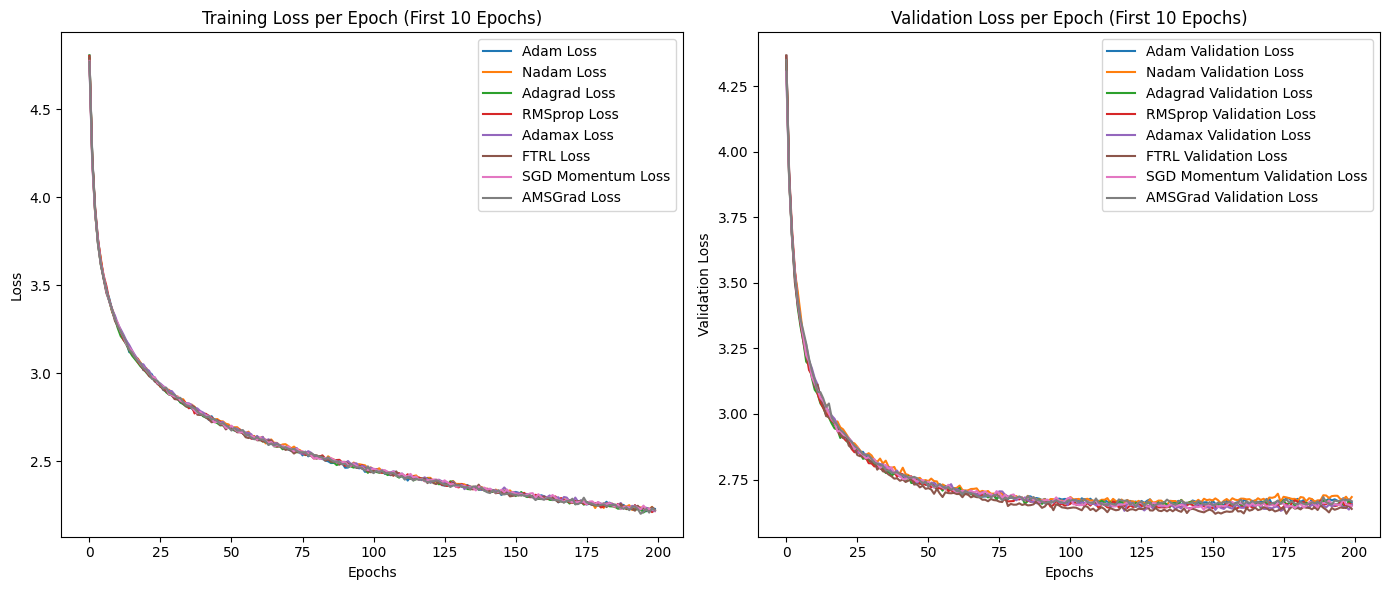

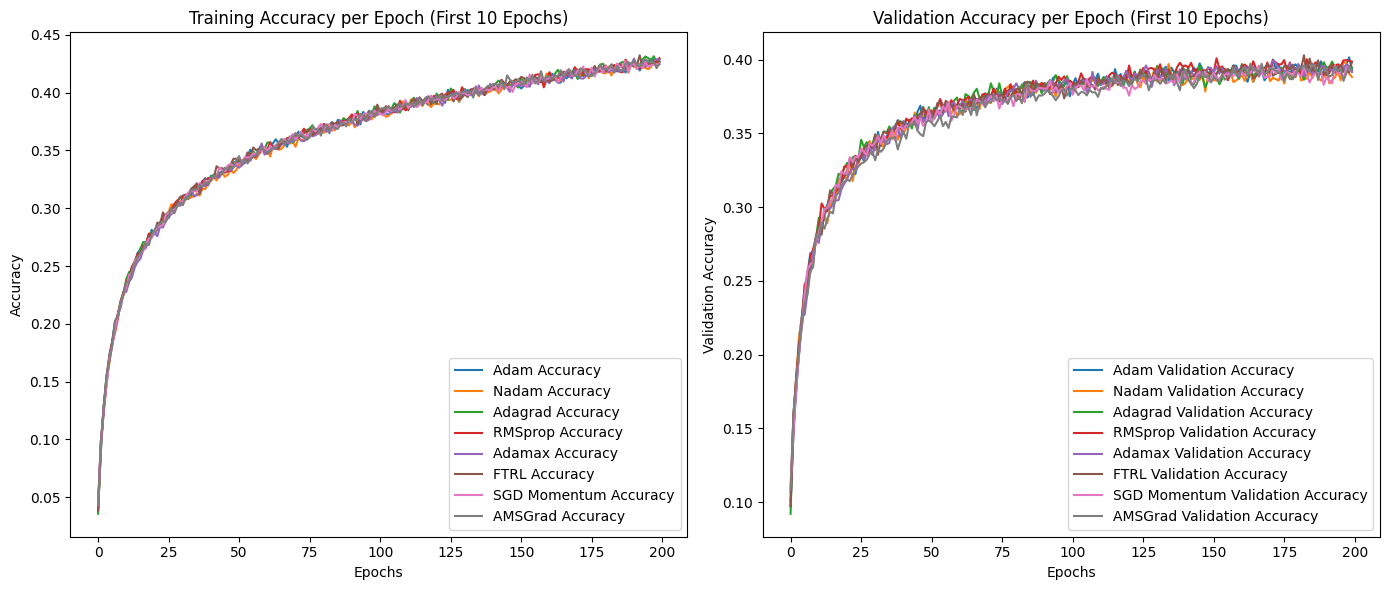

In [16]:
import matplotlib.pyplot as plt

def plot_histories(histories, epochs_range, title_suffix=''):
    epochs_range = list(epochs_range)  
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['loss'][i] for i in epochs_range], label=f'{label} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['val_loss'][i] for i in epochs_range], label=f'{label} Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss per Epoch {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['accuracy'][i] for i in epochs_range], label=f'{label} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training Accuracy per Epoch {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['val_accuracy'][i] for i in epochs_range], label=f'{label} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy per Epoch {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

histories = {
    'Adam': history_adam,
    'Nadam': history_nadam,
    'Adagrad': history_adagrad,
    'RMSprop': history_rmsprop,
    'Adamax': history_adamax,
    'FTRL': history_ftrl,
    'SGD Momentum': history_sgd_momentum,
    'AMSGrad': history_amsgrad
}

plot_histories(histories, range(0, 200), title_suffix='(First 10 Epochs)')

# plot_histories(histories, range(10, 20), title_suffix='(Epochs 10 to 20)')

## PCA 2D

In [23]:

# Define a custom callback to store weights
class WeightHistory(Callback):
    def __init__(self):
        super(WeightHistory, self).__init__()
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        current_weights = self.model.get_weights()
        weights_flat = np.concatenate([w.flatten() for w in current_weights])
        self.weights_history.append(weights_flat)

# Instantiate the callback
weight_history = WeightHistory()

# Train the model and collect weights
model = create_model(X_train.shape[1], optimizer=Adam())
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), callbacks=[weight_history])


Epoch 1/50


C:\Users\Rami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0300 - loss: 5.0069 - val_accuracy: 0.1026 - val_loss: 4.3364
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0876 - loss: 4.2956 - val_accuracy: 0.1529 - val_loss: 3.9014
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1244 - loss: 3.9495 - val_accuracy: 0.1964 - val_loss: 3.6379
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1583 - loss: 3.7444 - val_accuracy: 0.2083 - val_loss: 3.5187
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1701 - loss: 3.6292 - val_accuracy: 0.2281 - val_loss: 3.4139
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1776 - loss: 3.5534 - val_accuracy: 0.2428 - val_loss: 3.3493
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1938 - loss: 3.4752 - val_accuracy: 0.2531 - val_loss: 3.2622
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2081 - loss: 3.4134 - val_accuracy: 0.2621 - val_loss: 3.2190
Epo

In [24]:
from sklearn.decomposition import PCA

# Collect weights at each epoch to build the weight matrix
weights_matrix = np.array(weight_history.weights_history)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(weights_matrix)
direction1, direction2 = pca.components_

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first two principal components: {explained_variance}")
print(f"Total explained variance: {np.sum(explained_variance)}")

# Evaluate the loss along the grid
def evaluate_loss_along_directions(model, base_weights, direction1, direction2, grid_size=25, step_size=0.1):
    losses = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            new_weights_flat = (
                base_weights
                + (i - grid_size // 2) * step_size * direction1
                + (j - grid_size // 2) * step_size * direction2
            )
            
            # Set new weights to the model
            new_weights = []
            index = 0
            for w in weights:
                new_size = np.prod(w.shape)
                new_weights.append(new_weights_flat[index : index + new_size].reshape(w.shape))
                index += new_size
            model.set_weights(new_weights)
            
            # Evaluate the loss
            loss, _ = model.evaluate(X_test, y_test, verbose=0)
            losses[i, j] = loss
            
    return losses

# Get the base weights (final trained weights)
base_weights = np.concatenate([w.flatten() for w in model.get_weights()])

# Evaluate the loss along the grid
losses = evaluate_loss_along_directions(model, base_weights, direction1, direction2)


Explained variance by the first two principal components: [0.79080176 0.08985724]
Total explained variance: 0.8806589841842651


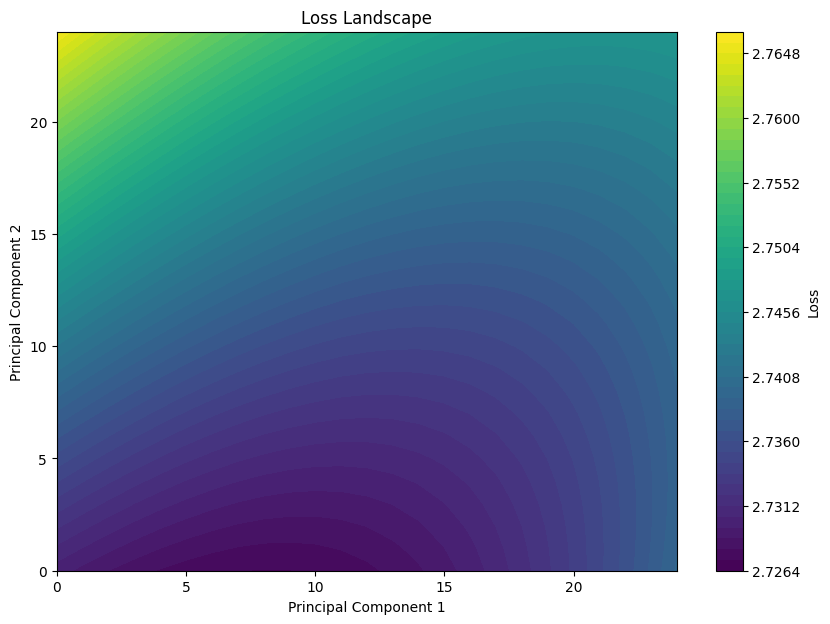

In [25]:

# Plot the loss landscape
plt.figure(figsize=(10, 7))
plt.contourf(losses, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Landscape')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## PCA 3D

In [26]:
from sklearn.decomposition import PCA

# Collect weights at each epoch to build the weight matrix
weights_matrix = np.array(weight_history.weights_history)

# Apply PCA
pca = PCA(n_components=3)
pca.fit(weights_matrix)
direction1, direction2, direction3 = pca.components_

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first three principal components: {explained_variance}")
print(f"Total explained variance: {np.sum(explained_variance)}")


Explained variance by the first three principal components: [0.7908016  0.08985727 0.0323899 ]
Total explained variance: 0.9130487442016602


In [27]:
def evaluate_loss_along_directions_3d(model, base_weights, direction1, direction2, direction3, grid_size=15, step_size=0.1):
    losses = np.zeros((grid_size, grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                new_weights_flat = (
                    base_weights
                    + (i - grid_size // 2) * step_size * direction1
                    + (j - grid_size // 2) * step_size * direction2
                    + (k - grid_size // 2) * step_size * direction3
                )
                
                # Set new weights to the model
                new_weights = []
                index = 0
                for w in weights:
                    new_size = np.prod(w.shape)
                    new_weights.append(new_weights_flat[index : index + new_size].reshape(w.shape))
                    index += new_size
                model.set_weights(new_weights)
                
                # Evaluate the loss
                loss, _ = model.evaluate(X_test, y_test, verbose=0)
                losses[i, j, k] = loss
            
    return losses

# Get the base weights (final trained weights)
base_weights = np.concatenate([w.flatten() for w in model.get_weights()])

# Evaluate the loss along the grid
losses = evaluate_loss_along_directions_3d(model, base_weights, direction1, direction2, direction3)


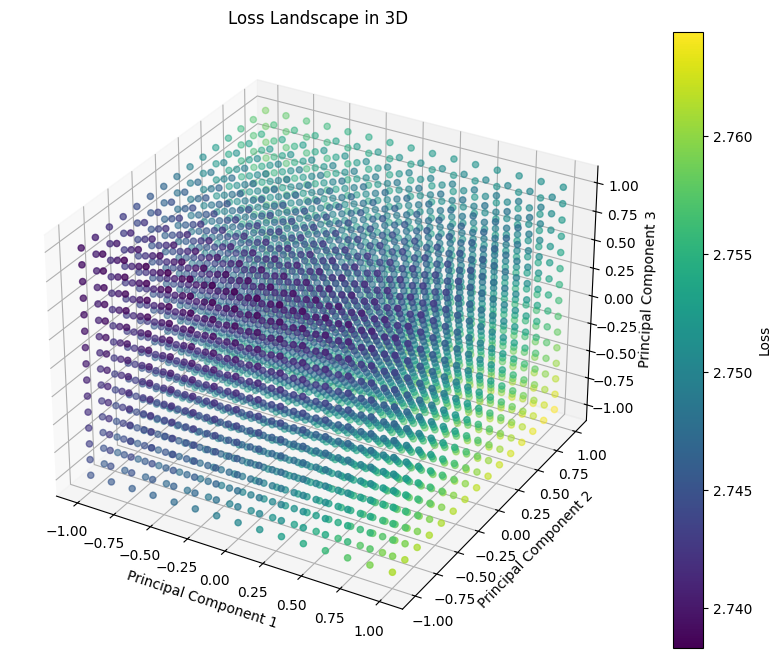

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D grid for plotting
x = np.linspace(-1, 1, losses.shape[0])
y = np.linspace(-1, 1, losses.shape[1])
z = np.linspace(-1, 1, losses.shape[2])
xx, yy, zz = np.meshgrid(x, y, z)

# Flatten the grid and losses for plotting
xx_flat = xx.flatten()
yy_flat = yy.flatten()
zz_flat = zz.flatten()
losses_flat = losses.flatten()

# Plot the loss landscape
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xx_flat, yy_flat, zz_flat, c=losses_flat, cmap='viridis')
plt.colorbar(sc, label='Loss')
ax.set_title('Loss Landscape in 3D')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


## Computing Gradients

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gradients(model, base_weights, direction1, direction2, direction3, step_size=0.1):
    gradients = []
    
    for direction in [direction1, direction2, direction3]:
        perturbed_weights_flat = base_weights + step_size * direction
        perturbed_weights = []
        index = 0
        for w in weights:
            new_size = np.prod(w.shape)
            perturbed_weights.append(perturbed_weights_flat[index : index + new_size].reshape(w.shape))
            index += new_size
        model.set_weights(perturbed_weights)
        
        loss, _ = model.evaluate(X_test, y_test, verbose=0)
        gradients.append(loss)
    
    return gradients

gradients = compute_gradients(model, base_weights, direction1, direction2, direction3)
gradients 
# Plot gradients
# fig, ax = plt.subplots()
# directions = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3']
# ax.bar(directions, gradients)
# ax.set_ylabel('Loss Gradient')
# ax.set_title('Loss Gradient Along Principal Components')
# plt.show()

[2.7482194900512695, 2.7476823329925537, 2.746741533279419]

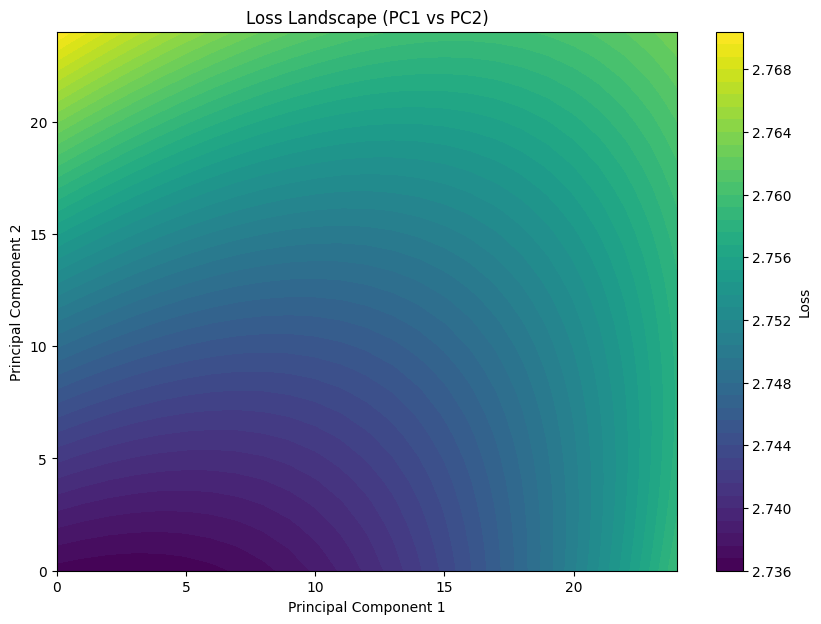

In [34]:
def evaluate_loss_along_directions_2d(model, base_weights, direction1, direction2, grid_size=25, step_size=0.1):
    losses = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            new_weights_flat = (
                base_weights
                + (i - grid_size // 2) * step_size * direction1
                + (j - grid_size // 2) * step_size * direction2
            )
            
            new_weights = []
            index = 0
            for w in weights:
                new_size = np.prod(w.shape)
                new_weights.append(new_weights_flat[index : index + new_size].reshape(w.shape))
                index += new_size
            model.set_weights(new_weights)
            
            # Evaluate the loss
            loss, _ = model.evaluate(X_test, y_test, verbose=0)
            losses[i, j] = loss
            
    return losses

losses_2d_12 = evaluate_loss_along_directions_2d(model, base_weights, direction1, direction2)

plt.figure(figsize=(10, 7))
plt.contourf(losses_2d_12, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Landscape (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


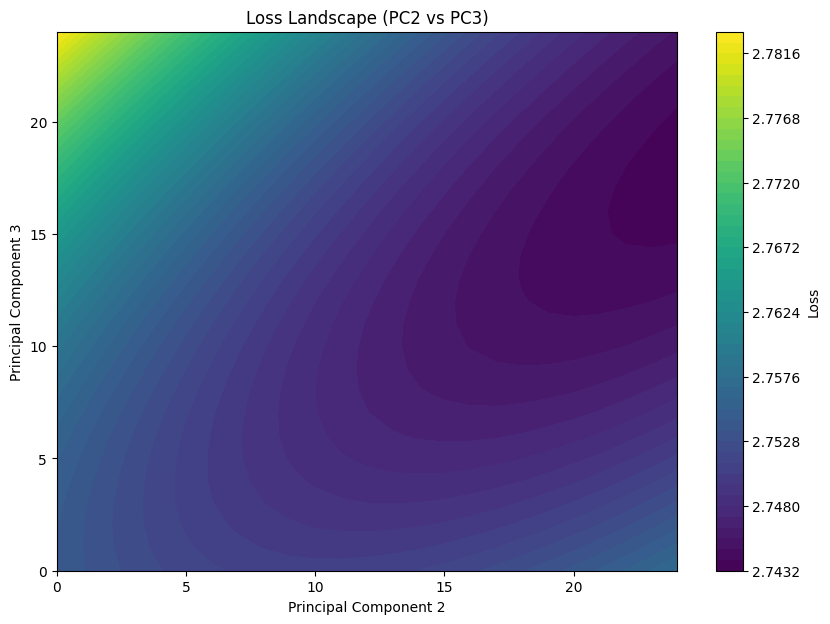

In [35]:
def evaluate_loss_along_directions_2d(model, base_weights, direction1, direction2, grid_size=25, step_size=0.1):
    losses = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            new_weights_flat = (
                base_weights
                + (i - grid_size // 2) * step_size * direction1
                + (j - grid_size // 2) * step_size * direction2
            )
            
            new_weights = []
            index = 0
            for w in weights:
                new_size = np.prod(w.shape)
                new_weights.append(new_weights_flat[index : index + new_size].reshape(w.shape))
                index += new_size
            model.set_weights(new_weights)
            
            loss, _ = model.evaluate(X_test, y_test, verbose=0)
            losses[i, j] = loss
            
    return losses

losses_2d_12 = evaluate_loss_along_directions_2d(model, base_weights, direction2, direction3)

plt.figure(figsize=(10, 7))
plt.contourf(losses_2d_12, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Landscape (PC2 vs PC3)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.show()


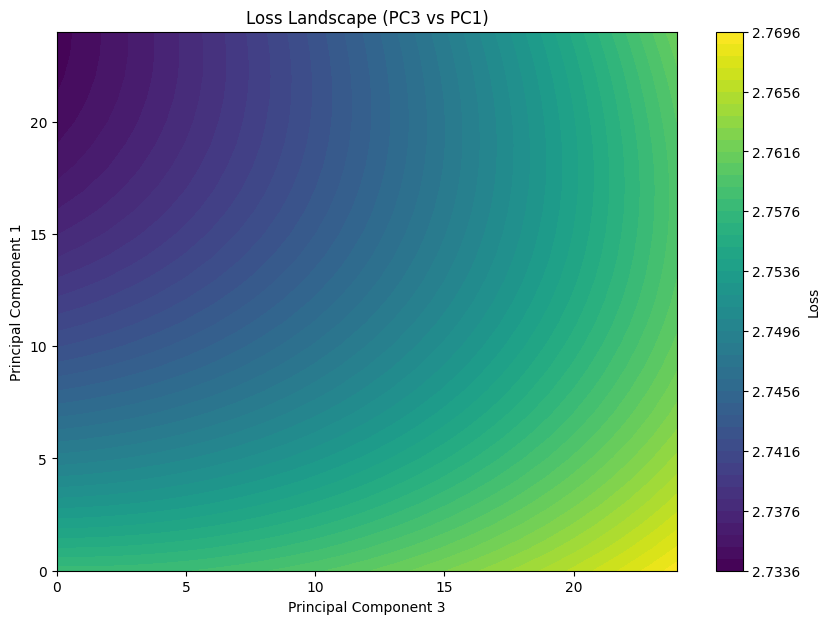

In [36]:
def evaluate_loss_along_directions_2d(model, base_weights, direction1, direction2, grid_size=25, step_size=0.1):
    losses = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            new_weights_flat = (
                base_weights
                + (i - grid_size // 2) * step_size * direction1
                + (j - grid_size // 2) * step_size * direction2
            )
            
            new_weights = []
            index = 0
            for w in weights:
                new_size = np.prod(w.shape)
                new_weights.append(new_weights_flat[index : index + new_size].reshape(w.shape))
                index += new_size
            model.set_weights(new_weights)
            
            loss, _ = model.evaluate(X_test, y_test, verbose=0)
            losses[i, j] = loss
            
    return losses

losses_2d_12 = evaluate_loss_along_directions_2d(model, base_weights, direction3, direction1)

plt.figure(figsize=(10, 7))
plt.contourf(losses_2d_12, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Landscape (PC3 vs PC1)')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 1')
plt.show()


# Tests randoms sans importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171624
[LightGBM] [Info] Number of data points in the train set: 19567, number of used features: 684
[LightGBM] [Info] Start training from score -5.404263
[LightGBM] [Info] Start training from score -5.359811
[LightGBM] [Info] Start training from score -5.577535
[LightGBM] [Info] Start training from score -6.514304
[LightGBM] [Info] Start training from score -4.474428
[LightGBM] [Info] Start training from score -8.495305
[LightGBM] [Info] Start training from score -6.885867
[LightGBM] [Info] Start training from score -6.837077
[LightGBM] [Info] Start training from score -7.173550
[LightGBM] [Info] Start training from score -3.880185
[LightGBM] [Info] Start training from score -3.875247
[LightGBM] [Info] Start training from score -6.937161
[LightGBM] [Info] Start training from score -6.662724
[Light

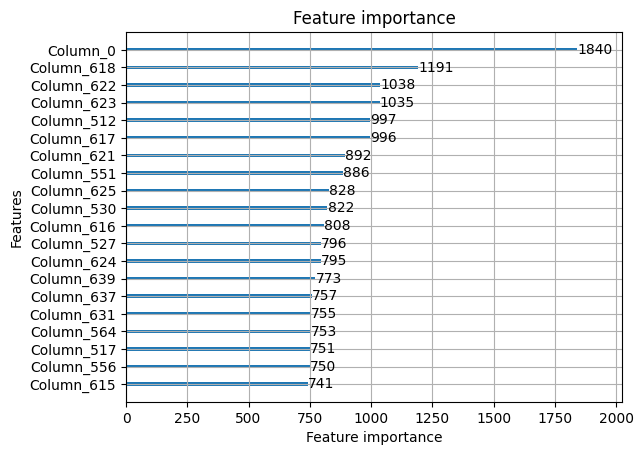

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_lgb = np.argmax(y_train_lgb, axis=1)
y_test_lgb = np.argmax(y_test_lgb, axis=1)

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
test_data = lgb.Dataset(X_test_lgb, label=y_test_lgb)

params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_lgb)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], valid_names=['valid'])

y_pred_lgb = bst.predict(X_test_lgb, num_iteration=bst.best_iteration)
y_pred_lgb = np.argmax(y_pred_lgb, axis=1)

accuracy_lgb = accuracy_score(y_test_lgb, y_pred_lgb)
print(f"LightGBM Test Accuracy: {accuracy_lgb:.4f}")

lgb.plot_importance(bst, max_num_features=20)
plt.show()


In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled, np.argmax(y, axis=1), test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=len(np.unique(y_train_knn)), random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = adjusted_rand_score(np.argmax(y, axis=1), kmeans_labels)
print(f"K-Means Adjusted Rand Index: {kmeans_score:.4f}")

spectral = SpectralClustering(n_clusters=len(np.unique(y_train_knn)), random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_scaled)
spectral_score = adjusted_rand_score(np.argmax(y, axis=1), spectral_labels)
print(f"Spectral Clustering Adjusted Rand Index: {spectral_score:.4f}")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)
knn_accuracy = accuracy_score(y_test_knn, y_pred_knn)
print(f"KNN Test Accuracy: {knn_accuracy:.4f}")


K-Means Adjusted Rand Index: 0.0200
Spectral Clustering Adjusted Rand Index: 0.0199
KNN Test Accuracy: 0.2296


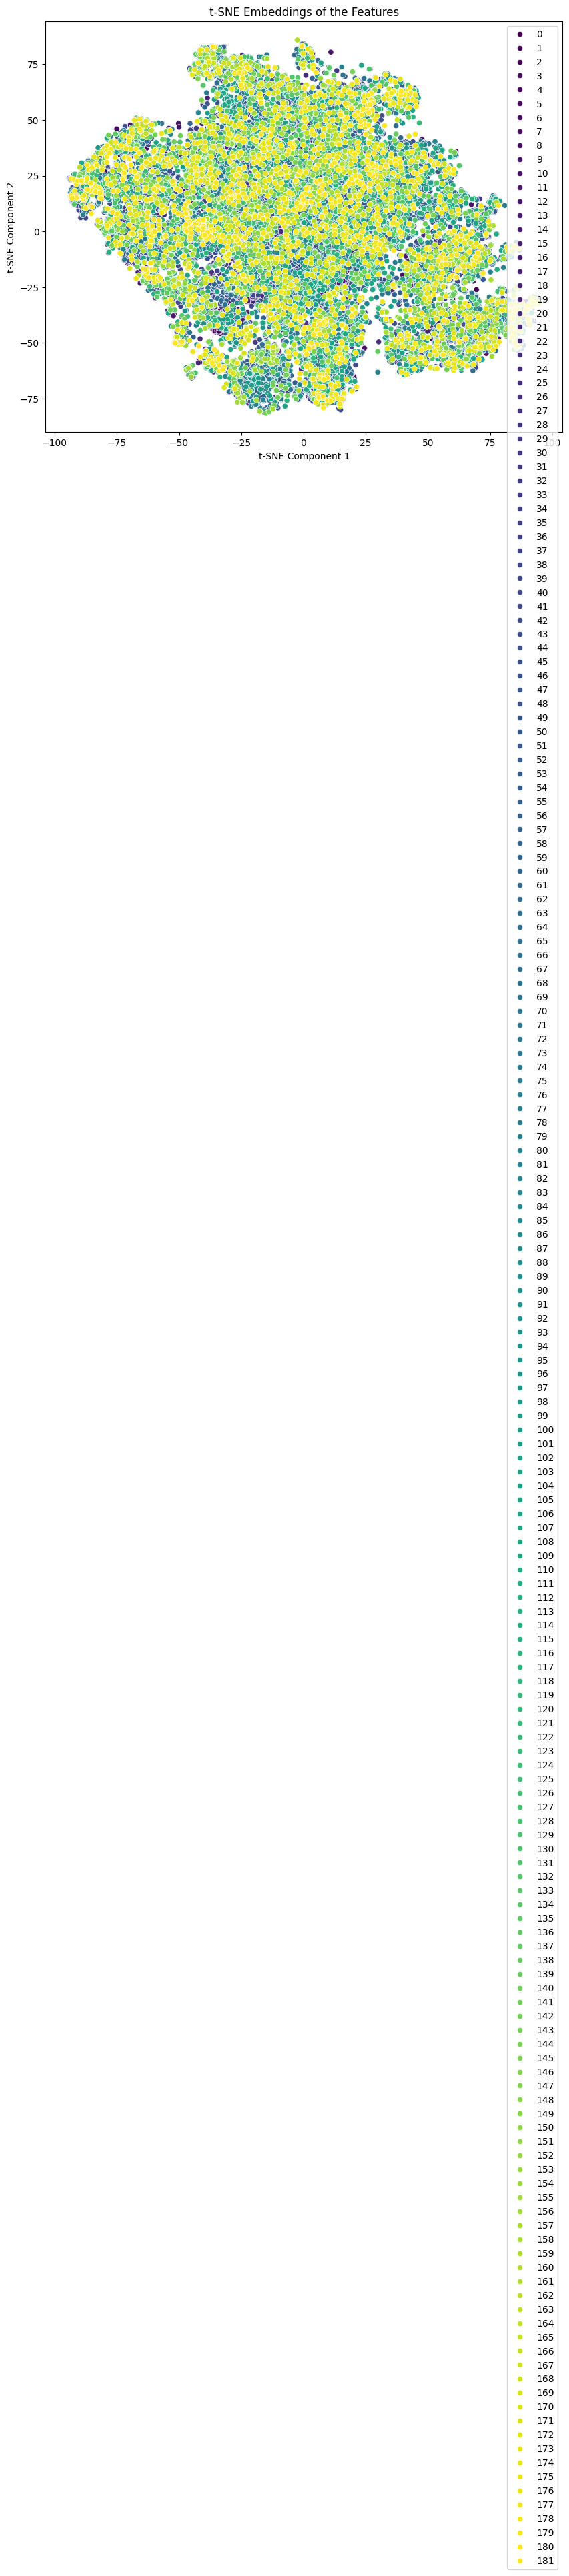

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=np.argmax(y, axis=1), palette='viridis', legend='full')
plt.title("t-SNE Embeddings of the Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
